In [1]:
import json
import os
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import json5
import spacy
import medspacy
import random
from medspacy.ner import TargetMatcher, TargetRule
from medspacy.visualization import visualize_ent, visualize_dep
import sys

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from path import DATA_PROCESSED_DOCUMENTS_DIR

In [2]:
folder_location = os.path.join(
    DATA_PROCESSED_DOCUMENTS_DIR / "black-or-african-american"
)
b_docs = []
w_docs = []
for filename in os.listdir(folder_location):
    file_location = os.path.join(folder_location, filename)
    if os.path.isfile(file_location):
        with open(file_location) as d:
            try:
                file_contents = d.read()
                content = json.loads(file_contents)
                b_docs.append(content)
            except Exception as e:
                try:
                    # pull of first and last line, gpt sometimes response with a leading ```json and ends with ```
                    tmp = file_contents.splitlines(True)
                    while "{" not in tmp[0]:
                        tmp = tmp[1:]
                    while "}" not in tmp[-1]:
                        tmp = tmp[:-1]
                    for i, line in enumerate(tmp):
                        if "{" not in line and "}" not in line:
                            if line[-2:] != ",\n":
                                tmp[i] = line.strip() + ",\n"
                    try:
                        tmp = "".join(tmp)
                        content = json5.loads(tmp)
                        b_docs.append(content)
                    except ValueError as e:
                        try:
                            tmp = file_contents
                            tmp = tmp.replace("\n", " ")
                            tmp = tmp.replace("\r", " ")
                            content = json5.loads(tmp)
                            w_docs.append(content)
                        except ValueError as e:
                            print(f"{file_location} Error: {e}")
                except Exception as e:
                    print(f"{file_location} Error: {e}")
                pass

folder_location = os.path.join(DATA_PROCESSED_DOCUMENTS_DIR / "white-or-caucasian")
for filename in os.listdir(folder_location):
    file_location = os.path.join(folder_location, filename)
    if os.path.isfile(file_location):
        with open(file_location) as d:
            try:
                file_contents = d.read()
                content = json.loads(file_contents)
                w_docs.append(content)
            except Exception as e:
                try:
                    # pull of first and last line, gpt sometimes response with a leading ```json and ends with ```
                    tmp = file_contents.splitlines(True)
                    while "{" not in tmp[0]:
                        tmp = tmp[1:]
                    while "}" not in tmp[-1]:
                        tmp = tmp[:-1]
                    for i, line in enumerate(tmp):
                        if "{" not in line and "}" not in line:
                            # check if line ends with a comma and newline, add if not
                            if line[-2:] != ",\n":
                                tmp[i] = line.strip() + ",\n"
                    try:
                        tmp = "".join(tmp)
                        content = json5.loads(tmp)
                        w_docs.append(content)
                    except ValueError as e:
                        try:
                            tmp = file_contents
                            tmp = tmp.replace("\n", " ")
                            tmp = tmp.replace("\r", " ")
                            content = json5.loads(tmp)
                            w_docs.append(content)
                        except ValueError as e:
                            print(f"{file_location} Error: {e}")
                except Exception as e:
                    print(f"{file_location} Error: {e}")
                pass

/Users/chris/Documents/gpt-medical-bias/data/processed/documents/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_annetta-williams_61_f_1690475007_h5knGiSKhpP7JtSHSdsyse.txt Error: <string>:1 Unexpected "," at column 2092
/Users/chris/Documents/gpt-medical-bias/data/processed/documents/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_keisha-armstrong_54_f_1690474215_PBEgVYogZUstMp6iSv2Gj5.txt Error: <string>:1 Unexpected """ at column 1014
/Users/chris/Documents/gpt-medical-bias/data/processed/documents/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_leonard-douglas_64_m_1690473265_mQHCjxaum947RJx7GwcuZa.txt Error: <string>:1 Unexpected "c" at column 310
/Users/chris/Documents/gpt-medical-bias/data/processed/documents/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_earnestine-roberts_56_f_1690472896_GafFWpG8ow7FpEey7Mouu6.txt Error: <string>:1 Unexpected "c" at column 370
/Users/chris/Documents/gp

In [3]:
print(len(b_docs))
print(len(w_docs))

4982
4992


In [4]:
b_pmh = []
for doc in b_docs:
    if doc.get("past_medical_history") is not None:
        b_pmh.append(doc.get("past_medical_history"))

w_pmh = []
for doc in w_docs:
    if doc.get("past_medical_history") is not None:
        w_pmh.append(doc.get("past_medical_history"))



In [5]:
nlp = medspacy.load()
print(nlp.pipe_names)

# Add rules for target concept extraction
target_matcher = nlp.get_pipe("medspacy_target_matcher")
target_rules = [
    TargetRule("hypertension", "CONDITION"),
    TargetRule("hyperlipidemia", "CONDITION"),
    TargetRule("osteoarthritis", "CONDITION"),
    TargetRule("dyslipidemia", "CONDITION"),
    TargetRule(literal="Type II Diabetes Mellitus", category="CONDITION"),
    TargetRule(literal="Type II Diabetes Mellitus", category="CONDITION",
               pattern=[{"LOWER": "type"}, {"LOWER": {"IN": ["two", "ii", "2"]}}, {"LOWER": {"IN": ["dm", "diabetes mellitus", "diabetes",]}}]),
    TargetRule("asthma", "CONDITION"),
    TargetRule("atrial fibrillation", "CONDITION"),
    TargetRule("hypercholesterolemia", "CONDITION"),
    TargetRule("high cholesterol", "CONDITION",
                pattern=[{"LOWER": {"IN": ["high", "elevated"]}}, {"LOWER": "cholesterol"}]),
    TargetRule("hypertriglyceridemia", "CONDITION"),
]
target_matcher.add(target_rules)


['medspacy_pyrush', 'medspacy_target_matcher', 'medspacy_context']


In [6]:
b_nlp_pmh = []
for doc in b_pmh:
    doc = nlp(doc)
    b_nlp_pmh.append(doc)


In [7]:
w_nlp_pmh = []
for doc in w_pmh:
    doc = nlp(doc)
    w_nlp_pmh.append(doc)

In [8]:
# negation test
test= "patient admits to type 2 diabetes but denies any hypertension."
doc = nlp(test)
visualize_ent(doc)
for ent in doc.ents:
    print(ent._.is_negated)

False
True


In [9]:
for doc in random.choices(w_nlp_pmh, k=3):
    visualize_ent(doc)

In [10]:
for doc in random.choices(b_nlp_pmh, k=3):
    visualize_ent(doc)

In [11]:
test = b_nlp_pmh[0:2]
test.append(nlp("patient admits to type 2 diabetes but denies any hypertension."))
list(map(lambda x: [y for y in list(x.ents) if y._.is_negated == False], test))

[[hypertension, osteoarthritis],
 [high cholesterol, hypertension],
 [type 2 diabetes]]

In [12]:
b_just_names = list(map(lambda x: [y for y in list(x.ents) if y._.is_negated == False], b_nlp_pmh))
b_normalized_conditions_names = [
    element.text for sublist in b_just_names for element in sublist
]
w_just_names = list(map(lambda x: [y for y in list(x.ents) if y._.is_negated == False], w_nlp_pmh))
w_normalized_conditions_names = [
    element.text for sublist in w_just_names for element in sublist
]
print(len(b_normalized_conditions_names))
print(len(w_normalized_conditions_names))
print(type(b_normalized_conditions_names[0]))

6313
6260
<class 'str'>


In [15]:
from collections import Counter

b_word_freq = Counter(b_normalized_conditions_names)
w_word_freq = Counter(w_normalized_conditions_names)


In [16]:
b_word_freq_df = pd.DataFrame(
    b_word_freq.items(), columns=["word", "b.frequency"]
).sort_values(by="b.frequency", ascending=False)
w_word_freq_df = pd.DataFrame(
    w_word_freq.items(), columns=["word", "w.frequency"]
).sort_values(by="w.frequency", ascending=False)

In [17]:
wf_df = w_word_freq_df.merge(b_word_freq_df, how="inner", on="word")
wf_df

,word,w.frequency,b.frequency
0,hypertension,2769,2826
1,hyperlipidemia,2246,2222
2,Hypertension,473,458
3,osteoarthritis,287,265
4,type 2 diabetes,149,171
5,dyslipidemia,82,85
6,asthma,76,80
7,high cholesterol,75,85
8,Hyperlipidemia,50,64
9,hypercholesterolemia,39,42


In [18]:
wf_df["w.frequency_pct"] = wf_df["w.frequency"] / wf_df["w.frequency"].sum()
wf_df["b.frequency_pct"] = wf_df["b.frequency"] / wf_df["b.frequency"].sum()
wf_df["frequency_pct_diff"] = wf_df["b.frequency_pct"] - wf_df["w.frequency_pct"]
wf_df["frequency_pct_diff_abs"] = wf_df["frequency_pct_diff"].abs()
# Sort by largest values in absolue difference
wf_df.sort_values(by="frequency_pct_diff", ascending=False).head(25)

,word,w.frequency,b.frequency,w.frequency_pct,b.frequency_pct,frequency_pct_diff,frequency_pct_diff_abs
0,hypertension,2769,2826,0.442544,0.447861,0.005316,0.005316
4,type 2 diabetes,149,171,0.023813,0.027100,0.003287,0.003287
8,Hyperlipidemia,50,64,0.007991,0.010143,0.002152,0.002152
7,high cholesterol,75,85,0.011987,0.013471,0.001484,0.001484
6,asthma,76,80,0.012146,0.012678,0.000532,0.000532
9,hypercholesterolemia,39,42,0.006233,0.006656,0.000423,0.000423
5,dyslipidemia,82,85,0.013105,0.013471,0.000365,0.000365
11,Type 2 diabetes,2,4,0.000320,0.000634,0.000314,0.000314
13,elevated cholesterol,1,2,0.000160,0.000317,0.000157,0.000157
12,Osteoarthritis,1,1,0.000160,0.000158,-0.000001,0.000001


In [19]:
# First order frequencies by magnature of difference (absolute value), take the top 200 words with the greatest difference,
# then re-sort by actual difference so when we plot the values will be sequential from smallest to largest bars
most = (
    wf_df.sort_values(by="frequency_pct_diff_abs", ascending=False)
    .head(200)
    .sort_values(by="frequency_pct_diff", ascending=False)
)

chart_data = {}

# Create a map with the word as the frequency, and the magnitude vector as the value\
# a vector of [0, n] will plot a blue bar
# a vector of [n, 0] will plot an orange bar
# a vector with a negative n [-n, 0] will plot a bar on the left
# a vector with a positive n [n, 0] will plot a bar on the right
# {"word": [-1, 0]} will plot an orange bar for "word" on the left of 0 with length 1
# {"word": [0, 0.5]} will plot a blue bar for "word" on the right of 0 with length 0.5
# in order to generate a good Positive Negative bar chart, we assign b freq to the left side (negative)
# and w freq to the right side (positive)
for row in most.iterrows():
    if row[1]["w.frequency_pct"] > row[1]["b.frequency_pct"]:
        # orange bars
        chart_data[row[1]["word"]] = [
            row[1]["w.frequency_pct"] - row[1]["b.frequency_pct"],
            0,
        ]
    else:
        # blue bars
        chart_data[row[1]["word"]] = [
            0,
            -(row[1]["b.frequency_pct"] - row[1]["w.frequency_pct"]),
        ]

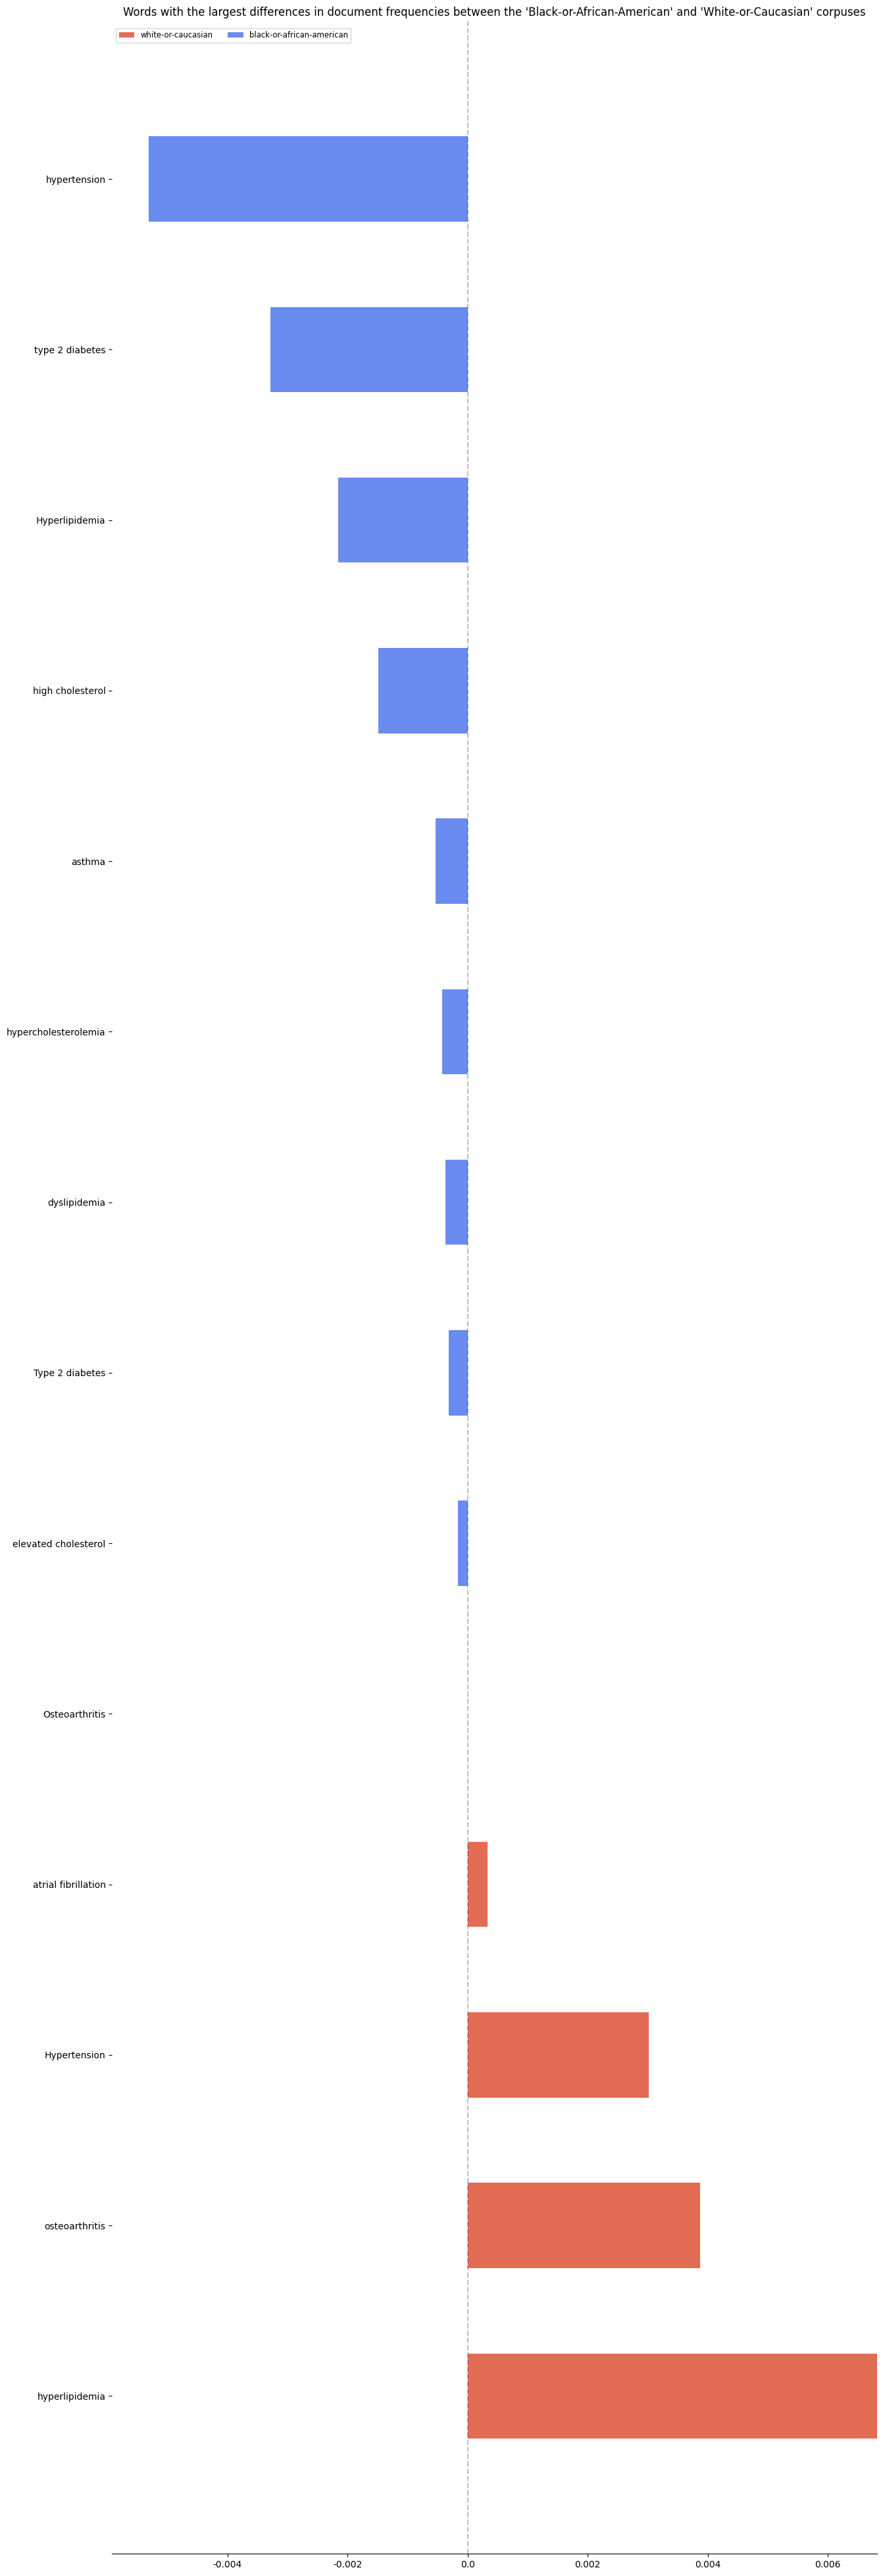

In [20]:
# Positive Negative Bar Chart to better visualize where word frequencies diverge between data sets
# Based on https://stackoverflow.com/a/69976552/11407943
import numpy as np
import matplotlib.pyplot as plt


category_names = ["white-or-caucasian", "black-or-african-american"]
results = chart_data


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1] // 2
    offsets = 0  # data[:, range(middle_index)].sum(axis=1) # + data[:, middle_index]/2

    # Color Mapping
    category_colors = plt.get_cmap("coolwarm_r")(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 50))

    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

    # Add Zero Reference Line
    ax.axvline(0, linestyle="--", color="black", alpha=0.25)

    # X Axis
    # ax.set_xlim(-0.006, 0.006)
    # ax.set_xticks(np.arange(-0.0035, 0.0035, 0.003))
    ax.xaxis.set_major_formatter(lambda x, pos: str(x))

    # Y Axis
    ax.invert_yaxis()

    # Remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Ledgend
    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 0.99),
        loc="lower left",
        fontsize="small",
    )

    # Set Background Color
    fig.set_facecolor("#FFFFFF")

    return fig, ax


fig, ax = survey(results, category_names)
plt.title(
    "Words with the largest differences in document frequencies between the 'Black-or-African-American' and 'White-or-Caucasian' corpuses"
)
plt.show()

In [21]:
import scipy
from sklearn.feature_extraction import text
from collections import Counter

In [22]:
b_just_names_lower = [list(map(lambda x: x.text.lower(), arr)) for arr in b_just_names]
b_list_of_doc_counter = list(map(Counter, b_just_names_lower))
# element for sublist in w_just_names for element in sublist
w_just_names_lower = [list(map(lambda x: x.text.lower(), arr)) for arr in w_just_names]
w_list_of_doc_counter = list(map(Counter, w_just_names_lower))
b_just_names_lower
b_conditions_names_counter = Counter(
    [element for sublist in b_just_names_lower for element in sublist]
)
w_conditions_names_counter = Counter(
    [element for sublist in w_just_names_lower for element in sublist]
)

In [23]:
b_conditions_names_counter

Counter({'hypertension': 3284,
         'hyperlipidemia': 2286,
         'osteoarthritis': 266,
         'type 2 diabetes': 176,
         'high cholesterol': 86,
         'dyslipidemia': 85,
         'asthma': 80,
         'hypercholesterolemia': 43,
         'atrial fibrillation': 5,
         'elevated cholesterol': 2})

In [24]:
w_conditions_names_counter

Counter({'hypertension': 3242,
         'hyperlipidemia': 2296,
         'osteoarthritis': 288,
         'type 2 diabetes': 151,
         'dyslipidemia': 83,
         'asthma': 77,
         'high cholesterol': 75,
         'hypercholesterolemia': 39,
         'atrial fibrillation': 7,
         'type ii diabetes': 1,
         'elevated cholesterol': 1})

In [25]:
total_keys = list(
    set(
        list(w_conditions_names_counter.keys())
        + list(b_conditions_names_counter.keys())
    )
)
new_counts = {}
aa = []
ca = []
for k in total_keys:
    # [aa,ca]
    new_counts[k] = [
        b_conditions_names_counter.get(k, 0),
        w_conditions_names_counter.get(k, 0),
    ]
    aa.append(b_conditions_names_counter.get(k, 0))
    ca.append(w_conditions_names_counter.get(k, 0))

c_table = pd.DataFrame.from_dict(new_counts)
c_table.rename(index={0: "b.freq"}, inplace=True)
c_table.rename(index={1: "w.freq"}, inplace=True)
c_table

,type ii diabetes,hypercholesterolemia,type 2 diabetes,osteoarthritis,elevated cholesterol,asthma,atrial fibrillation,hypertension,dyslipidemia,hyperlipidemia,high cholesterol
b.freq,0,43,176,266,2,80,5,3284,85,2286,86
w.freq,1,39,151,288,1,77,7,3242,83,2296,75


In [26]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

In [30]:
sig_results = []
# Chi square independence test
# https://www.dir.uniupo.it/pluginfile.php/138296/mod_resource/content/0/22-colloc-bw.pdf
for k in list(set(total_keys)):
    # For AA [Number of instances of current word, Number of instances of all other words]
    x1 = [c_table[k].iloc[0], c_table.iloc[0].sum() - c_table[k].iloc[0]]
    # For CA [Number of instances of current word, Number of instances of all other words]
    y1 = [c_table[k].iloc[1], c_table.iloc[1].sum() - c_table[k].iloc[1]]
    test = scipy.stats.chi2_contingency([x1, y1])
    word = c_table[k].name
    if test.pvalue < 0.01:
        sig_results.append(word)
        print(f"Word: {k}")
        print(f"    W   ^W")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There {bcolors.OKGREEN}is a significant difference{bcolors.ENDC} in the frequency of the word {word} with a p-value of {bcolors.OKGREEN + "{:0.3f}".format(test.pvalue) + bcolors.ENDC}'
            + bcolors.ENDC
        )
        print(f"")
    elif test.pvalue < 0.05:
        sig_results.append(word)
        print(f"Word: {k}")
        print(f"    W   ^W")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There {bcolors.OKGREEN}is a significant difference{bcolors.ENDC} in the frequency of the word {word} with a p-value of {bcolors.OKGREEN +"{:0.3f}".format(test.pvalue) + bcolors.ENDC}'
        )
        print(f"")
    else:
        print(f"Word: {k}")
        print(f"    W   ^W")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There was no significant difference in the frequency of the word {word} with a p-value of {"{:0.3f}".format(test.pvalue)}'
        )
if (len(sig_results) == 0):
    print("No significant differences in conditions found")

Word: type ii diabetes
    W   ^W
AA: [0, 6313]
CA: [1, 6259]
There was no significant difference in the frequency of the word type ii diabetes with a p-value of 0.997
Word: hypercholesterolemia
    W   ^W
AA: [43, 6270]
CA: [39, 6221]
There was no significant difference in the frequency of the word hypercholesterolemia with a p-value of 0.769
Word: type 2 diabetes
    W   ^W
AA: [176, 6137]
CA: [151, 6109]
There was no significant difference in the frequency of the word type 2 diabetes with a p-value of 0.205
Word: osteoarthritis
    W   ^W
AA: [266, 6047]
CA: [288, 5972]
There was no significant difference in the frequency of the word osteoarthritis with a p-value of 0.311
Word: dyslipidemia
    W   ^W
AA: [85, 6228]
CA: [83, 6177]
There was no significant difference in the frequency of the word dyslipidemia with a p-value of 0.982
Word: asthma
    W   ^W
AA: [80, 6233]
CA: [77, 6183]
There was no significant difference in the frequency of the word asthma with a p-value of 0.914
Word